# Configuration Code

In [1]:
%pip install gspread_pandas
%pip install fooddatacentral
%pip install pint
%pip install cufflinks
%pip install CFEDemands
%pip install eep153_tools
%pip install gnupg


from  scipy.optimize import linprog as lp
import numpy as np
import warnings
import pandas as pd
import eep153_tools
from eep153_tools.sheets import read_sheets
import fooddatacentral as fdc
import cufflinks as cf


from cfe import Regression

cf.go_offline()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached eep153_tools-0.11-py2.py3-none-any.whl (4.4 kB)
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.4/100.4 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for gnupg: filename=gnupg-2.3.1-py3-none-any.whl size=94620 sha256=641ce2addf28ea27f2bc62b0048203ea9187e28db6989edd7dae36be556579f3
  Stored in directory: /home/jovyan/.cache/pip/wheels/20/7e/30/7d702acd6a1e89911301cd9dbf9cb9870ca80c0e64bc2cde23
Successfully built gnupg
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning:

The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



Missing dependencies for OracleDemands.


# (A) Choice of Population, with supporting expenditure


We chose to analyze the Ugandan popultion of males and females 19-30 


Ugandan Expenditures of 2019-20 

In [2]:
Uganda_Data = '1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ'

x = read_sheets(Uganda_Data,sheet='Expenditures (2019-20)') 
x.columns.name = 'j'

Key available for students@eep153.iam.gserviceaccount.com.


Ugandan Household characteristics 

In [3]:
d = read_sheets(Uganda_Data,sheet="HH Characteristics") 
d.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.


In [4]:
x = x.groupby('j',axis=1).sum() #reducing duplicate columns
x = x.replace(0,np.nan) #reducing nulls
y = np.log(x.set_index(['i','t','m'])) #log of expenditure 
d.set_index(['i','t','m'],inplace=True) #specific labels for the axis


use = y.index.intersection(d.index)
y = y.loc[use,:]
d = d.loc[use,:]


#Filtering it down to our population of interest (M,F 19-30) 
b = read_sheets(Uganda_Data,sheet='RDI')
b = b.set_index('n')



Key available for students@eep153.iam.gserviceaccount.com.


# (A) Estimate Demand System


In [5]:
from cfe.estimation import drop_columns_wo_covariance
y = drop_columns_wo_covariance(y,min_obs=30)
use = y.index.intersection(d.index)
y = y.loc[use,:]
d = d.loc[use,:]

#y is log expednitures on food j by household i at a particular time
y = y.stack()
d = d.stack()
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

#setting up the regression
result = Regression(y=y,d=d)
#predicting expenditures
result.predicted_expenditures()

i                                 t        m         j             
00c9353d8ebe42faabf5919b81d7fae7  2019-20  Eastern   Beans             3555.677276
                                                     Beef              8401.789558
                                                     Biscuits           842.091521
                                                     Bread             3077.266434
                                                     Cabbages          1199.255865
                                                                          ...     
e07bc322c4884559b4b8ca75c945dd3e  2019-20  Northern  Sweet Potatoes    6706.688800
                                                     Tea                201.911345
                                                     Tomatoes          1349.788766
                                                     Waragi            4423.328381
                                                     Yam               2839.871449
Length: 101010, dty

Comparing Predicted Log Expenditures with Actual Expenditures

<IPython.core.display.Javascript object>


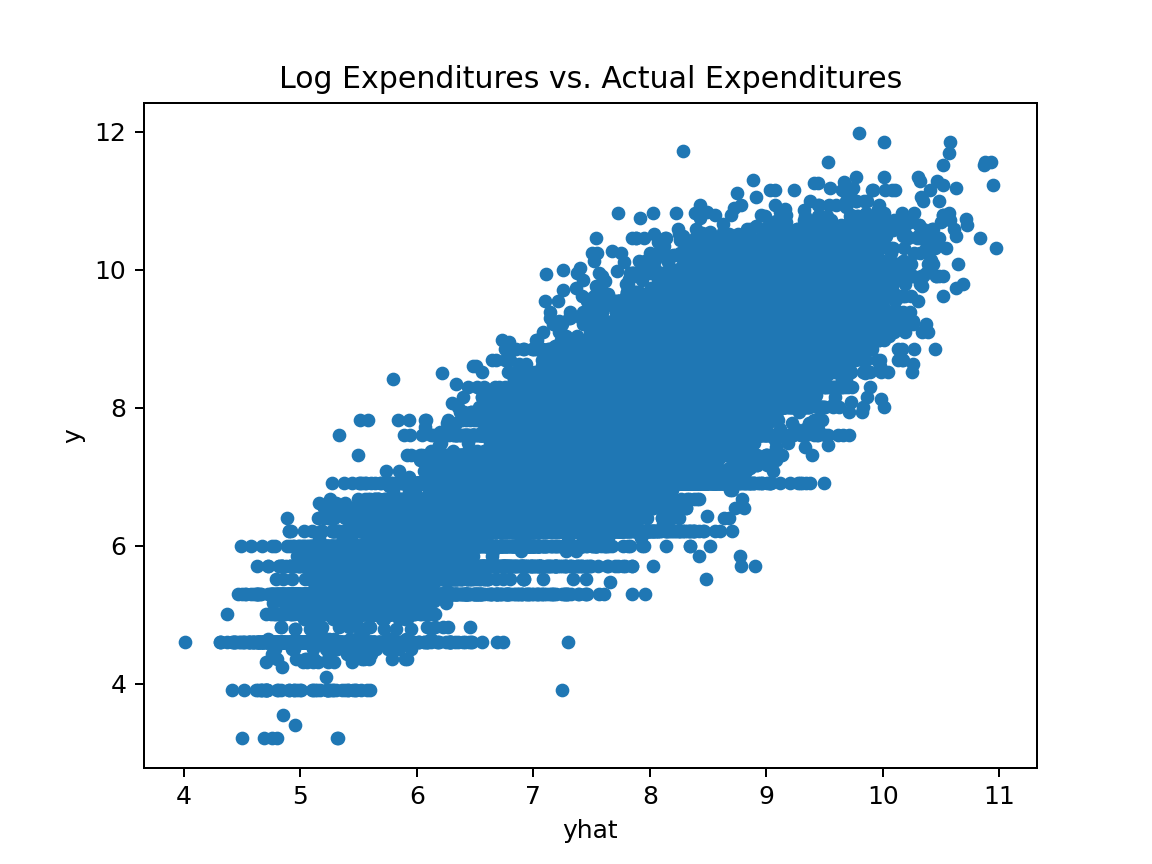

<AxesSubplot:title={'center':'Log Expenditures vs. Actual Expenditures'}, xlabel='yhat', ylabel='y'>

In [6]:
%matplotlib notebook
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y', title = 'Log Expenditures vs. Actual Expenditures')

Demand and Household Composition
Relative to the average consumption, the characteristics of age and sex affect the demand of the household in this factor. 

In [7]:
result.gamma

k,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+,log HSize,Constant
j,,,,,,,,,,,,,,,,
Beans,-0.124336,0.035231,0.090377,0.004499,-0.007870,0.022907,0.102685,-0.042510,0.022145,0.064256,0.063150,0.041227,0.011180,0.114473,0.391925,-0.765806
Beef,-0.133073,0.012580,0.015526,0.014861,0.082507,0.061304,0.189160,-0.042146,0.021119,-0.009366,0.048574,0.077610,0.170483,0.171712,0.252517,-0.676754
Biscuits,0.038606,-0.000608,-0.026963,0.101941,0.015177,0.244867,0.289385,0.243284,0.039812,-0.050499,-0.058406,0.046866,0.170904,-0.127918,-0.075380,-0.409758
Bread,-0.064686,0.027238,-0.092955,-0.008487,0.061894,0.057456,0.084374,-0.128560,0.073478,-0.041311,-0.019199,0.013019,0.074366,0.078168,0.398146,-0.751295
Cabbages,0.007378,-0.058572,0.029930,0.037955,-0.026252,0.036936,0.081504,-0.045031,0.033217,0.013162,0.042502,0.069609,0.030480,0.068790,0.232485,-0.513702
Cassava,0.019206,0.089485,0.105922,0.042049,-0.004145,0.072680,0.156273,-0.003705,0.134056,0.186236,0.135270,0.062836,0.098303,0.118365,0.148453,-0.711646
Chapati,-0.034054,-0.008517,0.065749,0.090993,0.023017,0.006971,-0.090070,0.007639,0.082807,-0.036377,-0.016584,0.067900,0.093947,0.153264,0.162986,-0.412577
Cooking Oil,-0.088741,-0.050446,-0.052850,0.011923,0.028813,0.017072,-0.079372,-0.086822,-0.083002,-0.041623,-0.007363,-0.034479,0.005265,0.052592,0.418256,-0.517449
Dodo,-0.083900,-0.011246,0.091461,0.040517,0.049264,0.073878,0.182246,-0.021156,0.021386,0.088145,-0.009156,0.044575,0.063169,0.162541,0.170590,-0.539539


# (B) Nutritional Content of Different Foods


In [8]:
food_nutrient = pd.read_excel("Uganda.xlsx", sheet_name = "FCT")
food_nutrient


,j,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
0,Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
1,Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
2,Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
3,Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
4,Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Tomatoes,180,9.0,10.0,150,100,39.0,3.0,5.94,0.19,0.37,420,0.0,0.80,127,2.0
99,Waragi,2630,0.0,0.0,0,0,0.0,0.0,0.00,0.00,0.00,0,0.0,0.00,0,0.0
100,Watermelon,300,6.1,4.0,30,70,75.5,2.4,1.78,0.21,0.33,280,0.0,0.45,81,1.0
101,Wheat (flour),3640,103.0,30.0,260,150,763.0,12.0,12.50,0.40,1.20,0,0.0,0.44,0,7.0


# (B) Nutritional Adequacy of Diet


In [9]:
expenditure = pd.read_excel("Uganda.xlsx", sheet_name = "Expenditures (2019-20)")
expenditure

,i,t,m,Beans,Beef,Beer,Biscuits,Bongo,Bread,"Butter, etc.",...,Sugarcane,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt
0,00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,3600.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4000.0,200.0,1000.0,NaN,NaN,NaN,3000.0,NaN
1,062da72d5d3a457e9336b62c8bb9096d,2019-20,Eastern,NaN,NaN,NaN,NaN,NaN,500.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,1000.0,4500.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,800.0,NaN,NaN,NaN,NaN,NaN
3,0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,2800.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5000.0,200.0,500.0,NaN,NaN,NaN,NaN,NaN
4,1013000201,2019-20,Central,NaN,NaN,17500.0,NaN,NaN,NaN,NaN,...,NaN,2000.0,NaN,400.0,2100.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,1200.0,10000.0,NaN,NaN,2800.0,NaN,NaN,...,NaN,NaN,6000.0,100.0,1000.0,NaN,NaN,NaN,1000.0,NaN
3005,c33f6cb57d9849949e08a7350dabb829,2019-20,Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2000.0,200.0,1000.0,NaN,NaN,NaN,NaN,NaN
3006,d10a687889de469687377204195f3db0,2019-20,Western,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2000.0,NaN,1000.0,NaN,NaN,NaN,NaN,NaN
3007,d24fa50d02c041969a42102d8ebdadc9,2019-20,Eastern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30000.0,NaN,1200.0,NaN,NaN,NaN,NaN,NaN


In [10]:
price = pd.read_excel("Uganda.xlsx", sheet_name = "Prices")
price = price[price["t"] == "2019-20"]
price

,t,m,Beans,Beef,Beer,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,...,Sugarcane,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt
28,2019-20,Central,2500.000000,12000,6000.000000,5000.0,1000.0,4500.0,10000.0,2683.028286,...,1679.389313,1169.607843,1550.000000,13000.000000,671.755725,8000.0,1000.0,2875.0,3358.778626,5000.0
29,2019-20,Eastern,2275.000000,10000,6785.714286,2000.0,1000.0,4500.0,10000.0,1679.389313,...,1428.571429,1225.000000,794.444444,10000.000000,625.000000,6000.0,1600.0,2500.0,3465.103599,7200.0
30,2019-20,Northern,8833.333333,10000,6500.000000,2000.0,1000.0,5000.0,NaN,2683.028286,...,714.285714,1398.039216,1000.000000,10000.000000,625.000000,4000.0,2000.0,3000.0,5366.056572,7000.0
31,2019-20,Western,2200.000000,10000,5000.000000,2000.0,1250.0,4500.0,6250.0,2351.145038,...,1341.514143,1720.588235,735.294118,11666.666667,750.000000,6000.0,2000.0,3200.0,5038.167939,8600.0


In [11]:
foods = ['Beans', 'Beef', 'Beer', 'Biscuits', 'Bongo', 'Bread',
       'Butter, etc.', 'Cabbages', 'Cake', 'Cassava', 'Cassava (flour)',
       'Chapati', 'Cheese', 'Chicken', 'Cigarettes', 'Coffee', 'Cooking Oil',
       'Cornflakes', 'Dodo', 'Donut', 'Eggs', 'Fish (dried)', 'Fish (fresh)',
       'Garlic', 'Ghee', 'Ginger', 'Goat', 'Ground Nuts', 'Honey', 'Ice Cream',
       'Infant Formula', 'Irish Potatoes', 'Jackfruit', 'Jam/Marmalade',
       'Kabalagala', 'Macaroni/Spaghetti', 'Maize', 'Mangos', 'Matoke',
       'Milk (fresh)', 'Milk (powdered)', 'Millet', 'Onions', 'Oranges',
       'Other Alcohol', 'Other Drinks', 'Other Fruits', 'Other Juice',
       'Other Meat', 'Other Spices', 'Other Tobacco', 'Other Veg.',
       'Passion Fruits', 'Peas', 'Plantains', 'Pork', 'Rice', 'Salt', 'Samosa',
       'Sim Sim', 'Soda', 'Sorghum', 'Soybean', 'Sugar', 'Sugarcane',
       'Sweet Bananas', 'Sweet Potatoes', 'Tea', 'Tomatoes', 'Waragi', 'Water',
       'Wheat (flour)', 'Yam', 'Yogurt']
expenditure_and_price = expenditure.merge(price, how = "left", on = "m")
expenditure_and_price

,i,t_x,m,Beans_x,Beef_x,Beer_x,Biscuits_x,Bongo_x,Bread_x,"Butter, etc._x",...,Sugarcane_y,Sweet Bananas_y,Sweet Potatoes_y,Tea_y,Tomatoes_y,Waragi_y,Water_y,Wheat (flour)_y,Yam_y,Yogurt_y
0,00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,3600.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1428.571429,1225.000000,794.444444,10000.000000,625.000000,6000.0,1600.0,2500.0,3465.103599,7200.0
1,062da72d5d3a457e9336b62c8bb9096d,2019-20,Eastern,NaN,NaN,NaN,NaN,NaN,500.0,NaN,...,1428.571429,1225.000000,794.444444,10000.000000,625.000000,6000.0,1600.0,2500.0,3465.103599,7200.0
2,0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,1000.0,4500.0,NaN,NaN,NaN,NaN,NaN,...,1428.571429,1225.000000,794.444444,10000.000000,625.000000,6000.0,1600.0,2500.0,3465.103599,7200.0
3,0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,2800.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1428.571429,1225.000000,794.444444,10000.000000,625.000000,6000.0,1600.0,2500.0,3465.103599,7200.0
4,1013000201,2019-20,Central,NaN,NaN,17500.0,NaN,NaN,NaN,NaN,...,1679.389313,1169.607843,1550.000000,13000.000000,671.755725,8000.0,1000.0,2875.0,3358.778626,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,1200.0,10000.0,NaN,NaN,2800.0,NaN,NaN,...,1428.571429,1225.000000,794.444444,10000.000000,625.000000,6000.0,1600.0,2500.0,3465.103599,7200.0
3005,c33f6cb57d9849949e08a7350dabb829,2019-20,Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1679.389313,1169.607843,1550.000000,13000.000000,671.755725,8000.0,1000.0,2875.0,3358.778626,5000.0
3006,d10a687889de469687377204195f3db0,2019-20,Western,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1341.514143,1720.588235,735.294118,11666.666667,750.000000,6000.0,2000.0,3200.0,5038.167939,8600.0
3007,d24fa50d02c041969a42102d8ebdadc9,2019-20,Eastern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1428.571429,1225.000000,794.444444,10000.000000,625.000000,6000.0,1600.0,2500.0,3465.103599,7200.0


In [12]:
for food in foods:
    exp = str(food) + "_x"
    price = str(food) + "_y"
    expenditure_and_price[food] = expenditure_and_price[exp]/expenditure_and_price[price]
household_consumption = expenditure_and_price[foods].fillna(0)
household_consumption

,Beans,Beef,Beer,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,Cake,Cassava,...,Sugarcane,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt
0,1.582418,0.00,0.000000,0.0,0.0,0.000000,0.0,0.833636,0.0,4.857143,...,0.0,0.000000,5.034965,0.020000,1.600000,0.0,0.0,0.0,0.865775,0.0
1,0.000000,0.00,0.000000,0.0,0.0,0.111111,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.439560,0.45,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,3.238095,...,0.0,0.000000,0.000000,0.000000,1.280000,0.0,0.0,0.0,0.000000,0.0
3,1.230769,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,2.590476,...,0.0,0.000000,6.293706,0.020000,0.800000,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.00,2.916667,0.0,0.0,0.000000,0.0,0.000000,0.0,2.857143,...,0.0,1.709975,0.000000,0.030769,3.126136,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,0.527473,1.00,0.000000,0.0,2.8,0.000000,0.0,0.297727,0.0,2.590476,...,0.0,0.000000,7.552448,0.010000,1.600000,0.0,0.0,0.0,0.288592,0.0
3005,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.785714,...,0.0,0.000000,1.290323,0.015385,1.488636,0.0,0.0,0.0,0.000000,0.0
3006,0.909091,0.00,0.000000,0.0,0.0,0.000000,0.0,0.425325,0.0,0.000000,...,0.0,0.000000,2.720000,0.000000,1.333333,0.0,0.0,0.0,0.000000,0.0
3007,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,37.762238,0.000000,1.920000,0.0,0.0,0.0,0.000000,0.0


In [13]:
#household dempgrahics 
household = pd.read_excel("Uganda.xlsx", sheet_name = "HH Characteristics")
household_19_20 = household[household["t"] == "2019-20"]
household_19_20 

,i,t,m,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+,log HSize
1,00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,1.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.945910
6,062da72d5d3a457e9336b62c8bb9096d,2019-20,Eastern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
8,0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.386294
10,0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.609438
18,1013000201,2019-20,Central,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24349,c33f6cb57d9849949e08a7350dabb829,2019-20,Central,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
24352,d10a687889de469687377204195f3db0,2019-20,Western,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.098612
24354,d24fa50d02c041969a42102d8ebdadc9,2019-20,Eastern,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.079442
24357,e07bc322c4884559b4b8ca75c945dd3e,2019-20,Northern,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.945910


In [14]:
household_consumption['i'] = expenditure["i"]
household_consumption = household_consumption.merge(household_19_20, how = "left", on = "i")
household_consumption

,Beans,Beef,Beer,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,Cake,Cassava,...,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+,log HSize
0,1.582418,0.00,0.000000,0.0,0.0,0.000000,0.0,0.833636,0.0,4.857143,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.945910
1,0.000000,0.00,0.000000,0.0,0.0,0.111111,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
2,0.439560,0.45,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,3.238095,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.386294
3,1.230769,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,2.590476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.609438
4,0.000000,0.00,2.916667,0.0,0.0,0.000000,0.0,0.000000,0.0,2.857143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,0.527473,1.00,0.000000,0.0,2.8,0.000000,0.0,0.297727,0.0,2.590476,...,1.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,2.197225
3005,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.785714,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3006,0.909091,0.00,0.000000,0.0,0.0,0.000000,0.0,0.425325,0.0,0.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.098612
3007,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.079442


In [15]:
RDI = pd.read_excel("Uganda.xlsx", sheet_name = "RDI")
RDI

,n,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
0,Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
1,Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
2,Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
3,Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
4,Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
5,Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
6,Iron,7.0,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
7,Magnesium,80.0,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
8,Niacin,6.0,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0
9,Phosphorus,460.0,460.0,500.0,500.0,1250.0,1250.0,1250.0,1250.0,700.0,700.0,700.0,700.0,700.0,700.0


In [16]:
x = household_consumption[['F 00-03', 'F 04-08', 'F 09-13', 'F 14-18', 'F 19-30',
       'F 31-50', 'F 51+', 'M 00-03', 'M 04-08', 'M 09-13', 'M 14-18',
       'M 19-30', 'M 31-50', 'M 51+']]
x

,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+
0,1.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,0.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0
3005,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3006,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3007,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [17]:
y = RDI[['F 00-03', 'F 04-08', 'F 09-13', 'F 14-18', 'F 19-30',
       'F 31-50', 'F 51+', 'M 00-03', 'M 04-08', 'M 09-13', 'M 14-18',
       'M 19-30', 'M 31-50', 'M 51+']].transpose()
y

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
F 00-03,1000.0,13.0,14.0,150.0,700.0,130.0,7.0,80.0,6.0,460.0,3000.0,0.5,0.5,300.0,0.9,0.5,15.0,6.0,30.0,3.0
F 04-08,1200.0,19.0,16.8,200.0,1000.0,130.0,10.0,130.0,8.0,500.0,3800.0,0.6,0.6,400.0,1.2,0.6,25.0,7.0,55.0,5.0
F 09-13,1600.0,34.0,22.4,300.0,1300.0,130.0,8.0,240.0,12.0,1250.0,4500.0,0.9,0.9,600.0,1.8,1.0,45.0,11.0,60.0,8.0
F 14-18,1800.0,46.0,25.2,400.0,1300.0,130.0,15.0,360.0,14.0,1250.0,4700.0,1.0,1.0,700.0,2.4,1.2,65.0,15.0,75.0,9.0
F 19-30,2000.0,46.0,28.0,400.0,1000.0,130.0,18.0,310.0,14.0,700.0,4700.0,1.1,1.1,700.0,2.4,1.3,75.0,15.0,90.0,8.0
F 31-50,1800.0,46.0,25.2,400.0,1000.0,130.0,18.0,320.0,14.0,700.0,4700.0,1.1,1.1,700.0,2.4,1.3,75.0,15.0,90.0,8.0
F 51+,1600.0,46.0,22.4,400.0,1200.0,130.0,8.0,320.0,14.0,700.0,4700.0,1.1,1.1,700.0,2.4,1.5,75.0,15.0,90.0,8.0
M 00-03,1000.0,13.0,14.0,150.0,700.0,130.0,7.0,80.0,6.0,460.0,3000.0,0.5,0.5,300.0,0.9,0.5,15.0,6.0,30.0,3.0
M 04-08,1400.0,19.0,19.6,200.0,1000.0,130.0,10.0,130.0,8.0,500.0,3800.0,0.6,0.6,400.0,1.2,0.6,25.0,7.0,55.0,5.0
M 09-13,1800.0,34.0,25.2,300.0,1300.0,130.0,8.0,240.0,12.0,1250.0,4500.0,0.9,0.9,600.0,1.8,1.0,45.0,11.0,60.0,8.0


In [18]:
required_nutrients_household = x@y
required_nutrients_household.columns = RDI["n"]
required_nutrients_household

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Magnesium,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Vitamin E,Vitamin K,Zinc
0,11800.0,277.0,165.2,2450.0,8100.0,910.0,86.0,2030.0,88.0,6860.0,31000.0,6.6,6.6,4400.0,14.7,7.9,405.0,92.0,495.0,54.0
1,2200.0,56.0,30.8,400.0,1000.0,130.0,8.0,420.0,16.0,700.0,4700.0,1.3,1.2,900.0,2.4,1.3,90.0,15.0,120.0,11.0
2,6200.0,128.0,86.8,1100.0,3400.0,520.0,40.0,890.0,42.0,2320.0,15400.0,3.4,3.3,2200.0,6.6,3.6,195.0,42.0,270.0,25.0
3,8000.0,168.0,112.0,1450.0,5000.0,650.0,51.0,1180.0,56.0,3610.0,20700.0,4.4,4.3,2900.0,8.7,4.7,250.0,54.0,355.0,35.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,13600.0,280.0,190.4,2450.0,9000.0,1170.0,84.0,2000.0,96.0,7030.0,35900.0,7.6,7.4,5000.0,14.7,8.4,400.0,92.0,550.0,60.0
3005,1600.0,46.0,22.4,400.0,1200.0,130.0,8.0,320.0,14.0,700.0,4700.0,1.1,1.1,700.0,2.4,1.5,75.0,15.0,90.0,8.0
3006,6000.0,154.0,84.0,1200.0,3500.0,390.0,27.0,1150.0,46.0,2650.0,14100.0,3.7,3.5,2500.0,7.2,4.1,240.0,45.0,285.0,30.0
3007,13600.0,304.0,190.4,2550.0,8600.0,1040.0,82.0,2190.0,98.0,6810.0,34600.0,7.6,7.4,5100.0,15.3,8.6,450.0,95.0,610.0,63.0


In [19]:
food_consumed = ['Beans', 'Beef', 'Beer', 'Biscuits', 'Bongo',
       'Bread', 'Butter, etc.', 'Cabbages', 'Cake', 'Cassava',
       'Cassava (flour)', 'Chapati', 'Cheese', 'Chicken', 'Cigarettes',
       'Coffee', 'Cooking Oil', 'Cornflakes', 'Dodo', 'Donut', 'Eggs',
       'Fish (dried)', 'Fish (fresh)', 'Garlic', 'Ghee', 'Ginger', 'Goat',
       'Ground Nuts', 'Honey', 'Ice Cream', 'Infant Formula', 'Irish Potatoes',
       'Jackfruit', 'Jam/Marmalade', 'Kabalagala', 'Macaroni/Spaghetti',
       'Maize', 'Mangos', 'Matoke', 'Milk (fresh)', 'Milk (powdered)',
       'Millet', 'Onions', 'Oranges', 'Other Alcohol', 'Other Drinks',
       'Other Fruits', 'Other Juice', 'Other Meat', 'Other Spices',
       'Other Tobacco', 'Other Veg.', 'Passion Fruits', 'Peas', 'Plantains',
       'Pork', 'Rice', 'Salt', 'Samosa', 'Sim Sim', 'Soda', 'Sorghum',
       'Soybean', 'Sugar', 'Sugarcane', 'Sweet Bananas', 'Sweet Potatoes',
       'Tea', 'Tomatoes', 'Waragi', 'Water', 'Wheat (flour)', 'Yam', 'Yogurt']

In [20]:
food_nutrient = food_nutrient[food_nutrient['j'].isin(food_consumed)]
x_2 = household_consumption[food_nutrient['j']]
x_2 = x_2.fillna(0)
x_2

,Beef,Biscuits,Bongo,Bread,Cabbages,Cassava (flour),Chapati,Cooking Oil,Dodo,Eggs,...,Pork,Sim Sim,Soda,Sorghum,Sugar,Sugarcane,Sweet Bananas,Tomatoes,Waragi,Wheat (flour)
0,0.00,0.0,0.0,0.000000,0.833636,0.0,1.714286,0.810811,3.00,0.0,...,0.000000,0.0,0.60,0.000000,0.0,0.0,0.000000,1.600000,0.0,0.0
1,0.00,0.0,0.0,0.111111,0.000000,0.0,0.571429,0.000000,0.00,0.0,...,0.000000,0.0,0.60,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.45,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,...,0.000000,0.0,0.00,1.500000,0.0,0.0,0.000000,1.280000,0.0,0.0
3,0.00,0.0,0.0,0.000000,0.000000,0.0,0.857143,0.486486,2.40,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.800000,0.0,0.0
4,0.00,0.0,0.0,0.000000,0.000000,0.0,12.000000,0.660000,0.00,0.0,...,0.833333,0.0,0.72,0.000000,0.0,0.0,1.709975,3.126136,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,1.00,0.0,2.8,0.000000,0.297727,0.0,1.714286,0.432432,0.75,0.0,...,0.000000,0.0,0.90,0.000000,0.0,0.0,0.000000,1.600000,0.0,0.0
3005,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.90,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,1.488636,0.0,0.0
3006,0.00,0.0,0.0,0.000000,0.425325,0.0,0.000000,0.000000,0.00,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,1.333333,0.0,0.0
3007,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2.70,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,1.920000,0.0,0.0


In [21]:
y_2 = food_nutrient.iloc[:,1:].set_index(food_nutrient['j'])
y_2

,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Biscuits,4460,69.0,10.0,1030,430,741.0,28.0,34.70,3.26,3.50,0,0.5,0.22,0,6.0
Bongo,640,33.0,0.0,50,1620,45.0,1.0,1.00,1.50,0.20,370,4.4,0.36,0,6.0
Bread,2660,76.0,20.0,1110,1510,506.0,37.0,43.85,3.31,4.55,0,0.0,0.84,0,7.0
Cabbages,250,13.0,30.0,430,400,58.0,5.0,2.34,0.40,0.61,50,0.0,1.24,366,2.0
Cassava (flour),3140,26.0,40.0,360,310,766.0,19.0,14.00,0.50,3.10,70,0.0,7.00,720,7.0
Chapati,2750,91.0,20.0,240,860,557.0,14.0,21.42,0.97,2.67,0,0.0,0.34,0,8.0
Cooking Oil,8840,0.0,0.0,0,0,0.0,0.0,0.00,0.00,0.00,0,0.0,0.00,0,0.0
Dodo,230,25.0,0.0,850,2150,40.0,23.0,6.58,1.58,0.27,1460,0.0,1.92,433,9.0


In [22]:
consumed_nutrients = x_2@y_2
consumed_nutrients

,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
0,21027.690944,323.451558,202.437662,4666.320779,9877.025974,2794.193766,133.853896,96.268995,8.967455,11.717661,8142.253247,0.000,22.207995,3731.168052,59.467273
1,2154.984127,60.444444,13.650794,260.476190,689.206349,448.307937,12.711111,17.112222,0.922063,2.031270,0.000000,0.000,0.287619,0.000000,5.949206
2,6604.900000,267.320000,110.800000,505.000000,671.500000,1206.120000,79.190000,66.163200,3.213200,4.633600,537.600000,13.005,5.464000,192.160000,44.010000
3,14730.826255,197.071429,116.857143,2879.857143,6617.571429,2023.957143,101.628571,63.835429,5.951143,6.982571,6982.857143,0.000,18.956571,2077.285714,42.085714
4,43099.248832,1306.064951,330.960609,3812.382092,11009.045712,7323.413585,190.735000,324.901249,15.691581,41.353429,1380.943185,5.250,17.193850,581.867130,123.065556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,23103.063092,556.391883,232.931818,3350.094156,10280.305195,3201.853896,106.467208,122.487110,11.876662,14.293256,6400.743506,41.220,24.417182,3708.803896,95.188312
3005,594.954545,39.197727,20.886364,1045.295455,2152.863636,121.956818,25.765909,15.124500,1.794841,0.943795,1939.227273,0.000,3.278909,600.956818,11.677273
3006,8167.988312,172.347792,174.378788,1642.746753,698.234632,1535.940260,55.298052,75.744731,4.429249,7.395081,2090.409091,0.003,11.785226,712.916450,29.088745
3007,1046.600000,86.980000,23.200000,2621.000000,6043.000000,201.480000,68.260000,29.410800,4.690800,1.539400,4748.400000,0.000,6.960000,1427.740000,28.540000


In [23]:
required_nutrients_household = required_nutrients_household[consumed_nutrients.columns].fillna(0)
required_nutrients_household*7

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
0,82600.0,1939.0,1156.4,17150.0,56700.0,6370.0,602.0,616.0,46.2,46.2,30800.0,102.9,55.3,2835.0,378.0
1,15400.0,392.0,215.6,2800.0,7000.0,910.0,56.0,112.0,9.1,8.4,6300.0,16.8,9.1,630.0,77.0
2,43400.0,896.0,607.6,7700.0,23800.0,3640.0,280.0,294.0,23.8,23.1,15400.0,46.2,25.2,1365.0,175.0
3,56000.0,1176.0,784.0,10150.0,35000.0,4550.0,357.0,392.0,30.8,30.1,20300.0,60.9,32.9,1750.0,245.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,95200.0,1960.0,1332.8,17150.0,63000.0,8190.0,588.0,672.0,53.2,51.8,35000.0,102.9,58.8,2800.0,420.0
3005,11200.0,322.0,156.8,2800.0,8400.0,910.0,56.0,98.0,7.7,7.7,4900.0,16.8,10.5,525.0,56.0
3006,42000.0,1078.0,588.0,8400.0,24500.0,2730.0,189.0,322.0,25.9,24.5,17500.0,50.4,28.7,1680.0,210.0
3007,95200.0,2128.0,1332.8,17850.0,60200.0,7280.0,574.0,686.0,53.2,51.8,35700.0,107.1,60.2,3150.0,441.0


In [24]:
proportions = []
for nutrient in consumed_nutrients.columns:
    proportion = required_nutrients_household[nutrient]/consumed_nutrients[nutrient]
    proportions.append(proportion)

In [25]:
nutritional_adequancy = pd.DataFrame(proportions).transpose()
nutritional_adequancy.replace(np.inf, 0,inplace=True)
nutritional_adequancy.fillna(0)
nutritional_adequancy = nutritional_adequancy.drop(["Vitamin B-12"], axis = 1)
nutritional_adequancy

,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-6,Vitamin C,Zinc
0,0.561165,0.856388,0.816054,0.525039,0.820085,0.325675,0.642492,0.914105,0.735995,0.563252,0.540391,0.355728,0.108545,0.908062
1,1.020889,0.926471,2.256279,1.535649,1.450944,0.289979,0.629371,0.935004,1.409881,0.590763,0.000000,4.519868,0.000000,1.848986
2,0.938697,0.478827,0.783394,2.178218,5.063291,0.431135,0.505114,0.634794,1.058135,0.712189,4.092262,0.658858,1.014779,0.568053
3,0.543079,0.852483,0.958435,0.503497,0.755564,0.321153,0.501827,0.877256,0.739354,0.615819,0.415303,0.247935,0.120349,0.831636
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,0.588667,0.503242,0.817407,0.731323,0.875460,0.365413,0.788975,0.783756,0.639910,0.517727,0.781159,0.344020,0.107851,0.630329
3005,2.689281,1.173537,1.072470,0.382667,0.557397,1.065951,0.310488,0.925650,0.612868,1.165507,0.360969,0.457469,0.124801,0.685091
3006,0.734575,0.893542,0.481710,0.730484,5.012642,0.253916,0.488263,0.607303,0.835356,0.473288,1.195938,0.347893,0.336645,1.031327
3007,12.994458,3.495056,8.206897,0.972911,1.423134,5.161803,1.201289,3.332109,1.620193,4.807068,1.074046,1.235632,0.315183,2.207428


<IPython.core.display.Javascript object>


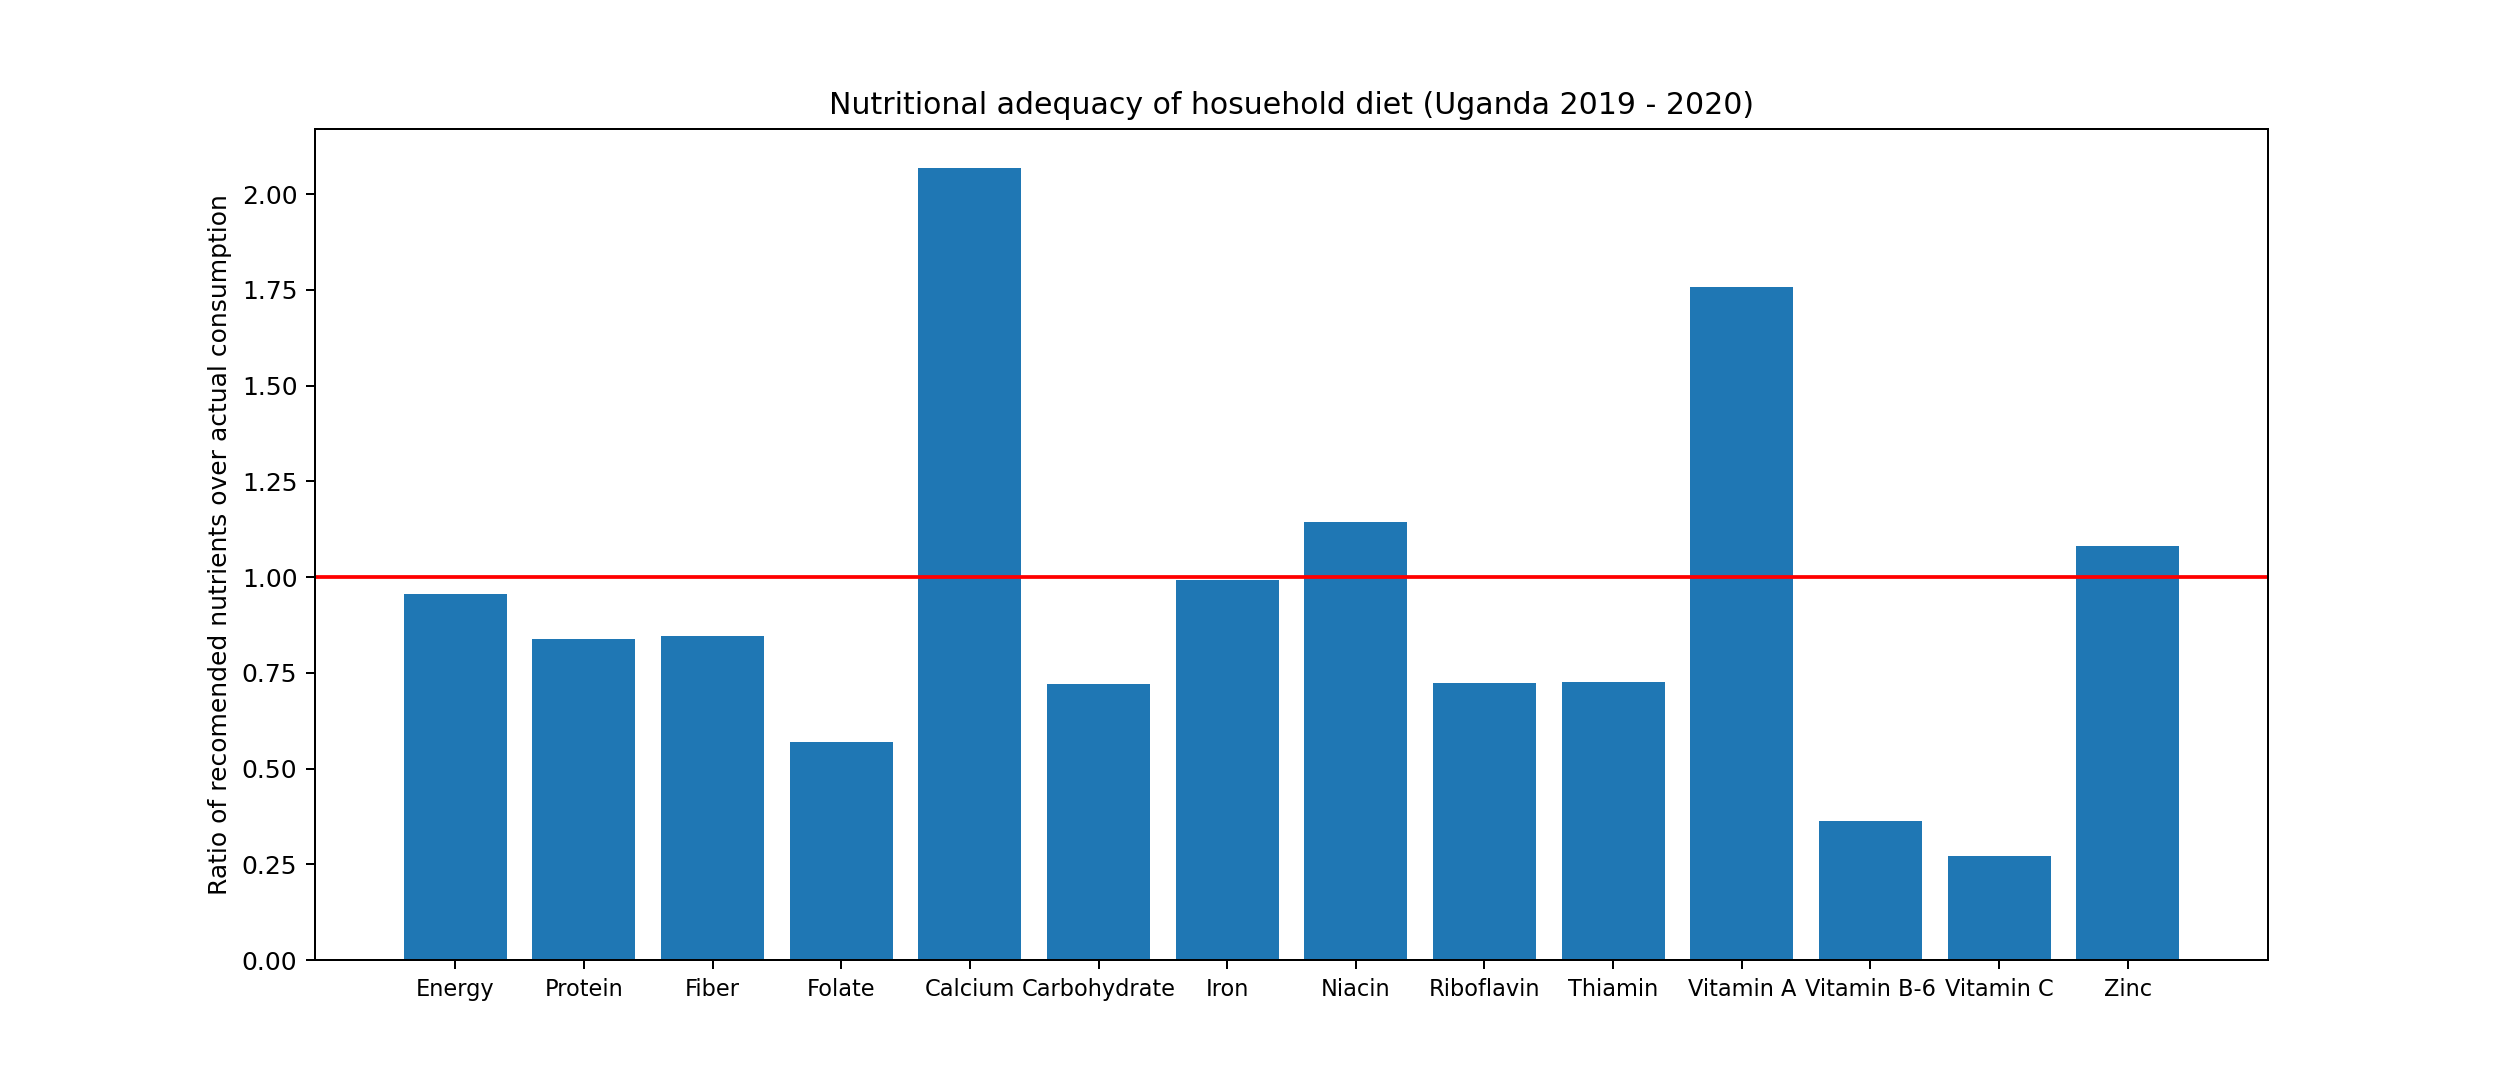

Text(0, 0.5, 'Ratio of recomended nutrients over actual consumption')

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.bar(nutritional_adequancy.mean().index,nutritional_adequancy.mean() )
plt.axhline(y = 1, color = 'r', linestyle = '-')
plt.title("Nutritional adequacy of hosuehold diet (Uganda 2019 - 2020)")
plt.xticks(fontsize= 9)
plt.ylabel("Ratio of recomended nutrients over actual consumption")